# A normal distribution sampler in python

Last year, I had the pleasure of attending a tutorial with the great [Petros Dellaportas](http://www.homepages.ucl.ac.uk/~ucakpde/#), a one-day primer in bayesian inference. One of the main sessions was about Markov chain Monte Carlo sampling, the technique whose name inspired one of the all-time greatest blog names (and blogs) ever: ['While my MCMC gently samples'](https://twiecki.io/)... and _also_ a game-changing statistical insight when it comes to sampling from complex statistical distributions. Following the session, I caught up with Petros and asked a dumb but useful question: 

<p><center>'So, I kind of understand MCMC now... but why does it matter?!'</center></p>

Petros being Petros, he was more than equal to my question:

<p><center>'MCMC is a tool to sample from complex distributions. Let's start with a simple distribution, the Normal Distribution. After this session, go and write a normal distribution sampler. Then, go and look up the Box-Mueller method, and you'll realise that MCMC matters - effective sampling from distributions is not trivial!'</center></p>

So, here's my naive attempt at sampling from the normal distribution. 

In [1]:
import numpy as np
from numpy.random import rand

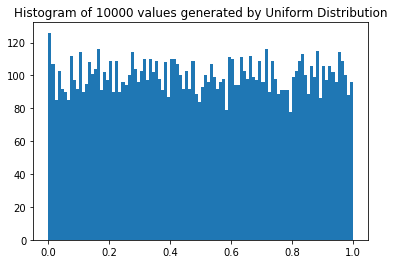

In [2]:

import matplotlib.pyplot as plt
%matplotlib inline 
n = 10000

test_set = rand(n)

plt.hist(test_set, bins=100)  
plt.title("Histogram of %i values generated by Uniform Distribution" %(n))
plt.show()

The probability density function of the normal distribution is defined as:

$$ f(x|\mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma ^2}}e ^ {- \frac{(x-\mu)^2}{2\sigma^2}}  $$

In [3]:
from math import pi

def norm(x_array, m, s):
    point_array = 1/np.sqrt(2* pi * s ** 2) * np.exp((-(x_array - mu)**2)/2*s**2)
    return(point_array)

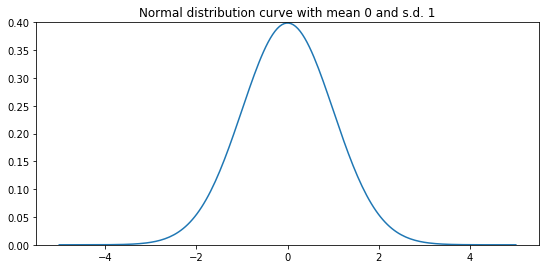

In [44]:
sigma = 1
mu = 0

x = np.linspace(-5,5,200)
y = norm(x, mu, sigma)


fig = plt.figure(figsize=(9,9))

n_axes = fig.add_subplot(211)

n_axes.set_autoscaley_on(False)
n_axes.set_ylim([0,0.4])

n_axes.plot(x, y)
plt.title("Normal distribution curve with mean %i and s.d. %i" %(mu, sigma))
plt.show()

Now, if we want to use the uniform sampler to generate a sample distribution X, such that $ X \sim N(0, 1)$, we need to know how to reshape our uniform distribution. To do this, we'll split the normal curve into strips, calculate the area under the curve for each strip, and use this to tell us how many uniformly distributed samples we need for each strip. 

Given an interval, we can calculate the y values at the beginning and end of the interval, then we use the trapezium rule to get the area of this slice:

$$ \frac{1}{2} * (a + b) * width $$  



In [45]:
sigma = 1
mu = 0


x_int = np.array([0,0.25])
x_width = x_int.max() - x_int.min()
y_vals = norm(x_int, mu, sigma)
area = 0.5 * y_vals.sum()*x_width

print(y_vals)
print(area)

[0.39894228 0.38666812]
0.09820129965053524


In [46]:
## function to calculate the trapezium area

def trap_area(y1, y2, width):
    return 0.5*(y1 + y2)* width

trap_area(*y_vals, x_width)

0.09820129965053524

In [47]:
sigma = 1
mu = 0
n_sigma = 4

## set our full interval to be 4 s.d. from the mean
## so with X~(0,1) we'll get an interval of (-4, 4)

interval = np.array([mu - sigma * n_sigma,mu + sigma * n_sigma])

## split this into k strips, which will control how fine-grain our slices are (let's say k = 80, intervals of 0.1)
k = 100

strip_width = (interval[1]-interval[0])/k
sub_strips = np.linspace(*interval, k + 1) ## 81 edges gives 80 strips
sub_strips_pairs = [np.array([sub_strips[p],sub_strips[p+1]]) for p in range(k)]


## also set how many samples we want 
n = 10000

## the area of the strip tells us how many values we want to select, as a proportion of n
## create an array of areas

areas = np.array([trap_area(*norm(s, mu, sigma), strip_width) for s in sub_strips_pairs])

print(areas.sum()) ## Check that my probabilities summed to 1. They don't quite, because the trapezium rule is an estimate.
                   ## We'll need a way to make sure this discrepancy doesn't affect the number of samples we want to produce at the end

0.99993608729814


In [48]:
## sense check


##  we can generate these using a uniformly distributed rv within that interval
bin_counts = np.round(areas * n)


x = bin_counts[2]
interval = sub_strips_pairs[2]


print("%i values in the interval (%f,%f)" %(x, *interval))
p = rand(int(x)) * strip_width + interval[0]
p.shape

0 values in the interval (-3.840000,-3.760000)


(0,)

Implementing largest remainder method to distribute remainder correctly

In [49]:
leftover = int(n - (np.floor(areas * n) ).sum())

## sort by decimal parts, and distribute leftovers 
# index = np.arange(len(bin_counts))
rounded_down = areas * n - np.floor(areas * n)


In [52]:
leftover

54

In [53]:
len(areas)

100

In [54]:
adjusted_bin_counts = np.floor(areas * n)

In [55]:
areas.sum()

0.99993608729814

In [56]:
rounded_down

array([0.12701709, 0.17371638, 0.23607186, 0.31876641, 0.4276867 ,
       0.57016926, 0.75527783, 0.99411024, 0.30013138, 0.68952575,
       0.1815606 , 0.79894677, 0.56818114, 0.51985024, 0.68887119,
       0.11464215, 0.84107206, 0.91645707, 0.39317079, 0.32713638,
       0.77705194, 0.80334608, 0.46684872, 0.82717297, 0.94081711,
       0.85901118, 0.62534961, 0.27326956, 0.82345226, 0.2812416 ,
       0.63418859, 0.84984081, 0.87390224, 0.62888827, 0.01339411,
       0.9020807 , 0.14646061, 0.57653834, 0.00332516, 0.22220982,
       0.01712529, 0.16540982, 0.44322109, 0.63132685, 0.52106752,
       0.92026658, 0.65885651, 0.59399068, 0.61442683, 0.64399437,
       0.64399437, 0.61442683, 0.59399068, 0.65885651, 0.92026658,
       0.52106752, 0.63132685, 0.44322109, 0.16540982, 0.01712529,
       0.22220982, 0.00332516, 0.57653834, 0.14646061, 0.9020807 ,
       0.01339411, 0.62888827, 0.87390224, 0.84984081, 0.63418859,
       0.2812416 , 0.82345226, 0.27326956, 0.62534961, 0.85901

In [57]:
#  = np.argpartition(a, -4)[-4:

largest_remainders = np.argpartition(rounded_down, -leftover)[-leftover:]


In [58]:
np.argpartition(rounded_down, 0)

array([38,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37,  0, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [59]:
largest_remainders

array([94,  5, 47, 62, 37, 51, 52, 48, 73, 69, 56, 26, 43, 30, 33, 66, 49,
       11, 64, 53, 50, 67, 68, 46, 45, 71,  6,  7, 74, 75, 76, 35, 78, 79,
       32, 31, 82, 83, 28, 85, 25, 24, 88, 23, 90, 21, 92, 93, 20, 17, 16,
        9, 14, 54])

In [60]:
adjusted_bin_counts[largest_remainders] += 1

In [61]:
sum(bin_counts - adjusted_bin_counts)

6.0

In [62]:
normal_sample = np.array([])

for i in range(k):
    count = adjusted_bin_counts[i]
    strip = sub_strips_pairs[i]
    sample = rand(int(count)) * strip_width + strip[0]
    normal_sample = np.append(normal_sample, sample)
    
len(normal_sample) ## sanity check

10000

In [63]:
normal_sample2 = np.array([])

for i in range(k):
    count = adjusted_bin_counts[i]
    strip = sub_strips_pairs[i]
    sample = rand(int(count)) * strip_width + strip[0]
    normal_sample2 = np.append(normal_sample2, sample)
    
len(normal_sample2) ## sanity check

10000

In [64]:
normal_sample == normal_sample2

array([False, False, False, ..., False, False, False])

In [77]:
idx = np.random.randint(len(normal_sample))
normal_sample[idx]

0.47114194036187274

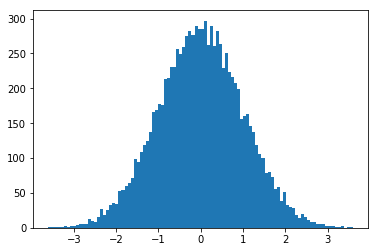

In [78]:
plt.hist(normal_sample, bins=100)
plt.show()

In [79]:
g = (trap_area(*norm(s, mu, sigma),0.1) for s in sub_strips_pairs)

In [80]:
class normal_distribution():
    
    def __init__(self, mu, sigma, num_sigma=4):
        self.mu = mu
        self.sigma = sigma
        self.tails = np.array([mu - sigma * num_sigma, mu + sigma * num_sigma])
        self.normal_sample = np.array([])
    
    def _generate_sample(self, bins, num_samples):
        
        strip_width = (self.tails[1] - self.tails[0]) / bins            
        sub_strips = np.linspace(*self.tails, bins + 1)
        sub_strips_pairs = [np.array([sub_strips[p], sub_strips[p + 1]]) for p in range(bins)]
    
        ## the area of the strip tells us how many values we want to select, as a proportion of the total number of samples
        ## create an array of areas

        area_array = np.array([self._trapezium_area(*self._normal_pdf(s, self.mu, self.sigma), strip_width) \
                               for s in sub_strips_pairs])

        bin_counts = np.round(area_array * num_samples)
        if bin_counts.sum() > num_samples:   
            print(bin_counts.sum())

        for i in range(bins):
            count = bin_counts[i]
            strip = sub_strips_pairs[i]
            strip_sample = rand(int(count)) * strip_width + strip[0]
            self.normal_sample = np.append(self.normal_sample, strip_sample)
            
            
    def _trapezium_area(self, y1, y2, width):
        return 0.5 * (y1 + y2) * width
          
    def _normal_pdf(self, x_array, mu, sigma):
        point_array = 1 / np.sqrt(2 * pi * sigma ** 2) * np.exp((-(x_array - mu) ** 2) / 2 * sigma ** 2)
        return(point_array)
        
    
    def sample(self,n, bins=80, num_samples=10000):
        
        self._generate_sample(bins, num_samples)
    
        if n > len(self.normal_sample):
            raise IndexError
        
        idx = np.random.randint(0,len(self.normal_sample), n)
        
        return self.normal_sample[idx]
        

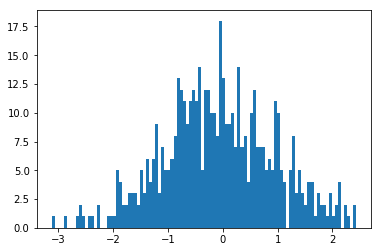

In [88]:
my_sampler = normal_distribution(0,1)
plt.hist(my_sampler.sample(500), bins=100)
plt.show()

In [89]:
from time import time

t = []

for n in range(50):
    t0 = time()
    sampler = normal_distribution(0,1)
    try:
    
        sampler.sample(1, bins=100, num_samples = n * 100000)
    except:
        pass
    t1 = time()
    
    t.append(t1 - t0)

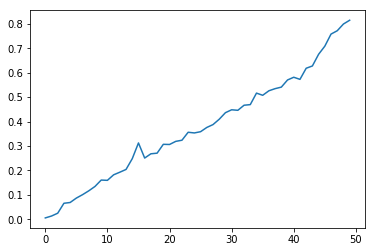

In [90]:
plt.plot(t)

In [53]:
sampler.normal_sample.shape

(4899686,)

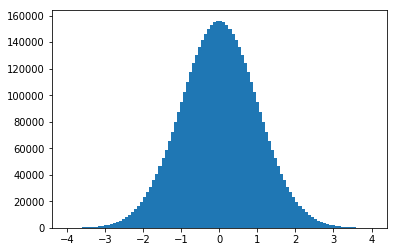

In [56]:
plt.hist(sampler.normal_sample, bins=100)
plt.show()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs


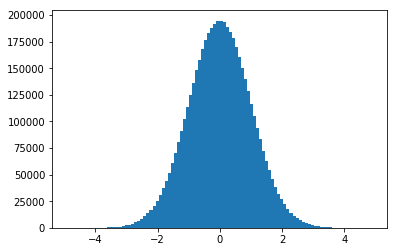

In [63]:
%time
plt.hist(np.random.normal(size=5000000), bins=100)
plt.show()

In [92]:
from scipy.stats import normaltest

print(normaltest(np.random.normal(size=5000000)))

print(normaltest(sampler.sample(n=500000)))

NormaltestResult(statistic=1.154570417443026, pvalue=0.5614204388873076)
NormaltestResult(statistic=2.8987645844629215, pvalue=0.2347152287438958)


NormaltestResult(statistic=0.29647734185217, pvalue=0.8622253022708851) 
 NormaltestResult(statistic=6.181178232820435, pvalue=0.04547515635094647)


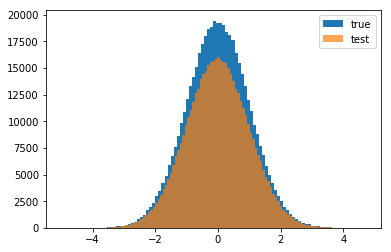

In [93]:
true = np.random.normal(size=500000)
test = sampler.sample(n=500000)

plt.hist(true, bins=100,label='true')
plt.hist(test, alpha=0.7, bins=100, label='test')
plt.legend(prop={'size': 10})

print(normaltest(true), '\n', normaltest(test))
plt.show()

In [96]:
from scipy import stats

test_stat, pvalue = stats.kstest(test, 'norm', args=(0, 4), N=5000000)
print("sample_N(0,1) vs. N(0, 1): KS=%.4f with p-value = %.4f." % (test_stat, pvalue))


sample_N(0,1) vs. N(0, 1): KS=0.2907 with p-value = 0.0000.


In [127]:
from math import sin, cos, pi, log, sqrt

## The Box-Mueller implementation

In [158]:
%%timeit
x1s = []
x2s = []
n = 1000000

for i in range(n):

    y1 = np.random.random()
    y2 = np.random.random()

    x1 = sqrt(-2 * log(y1)) * cos(2 * pi * y2)
    x2 = sqrt(-2 * log(y2)) * sin(2 * pi * y1)  
    
    x1s.append(x1)
    x2s.append(x2)

2.57 s ± 78.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


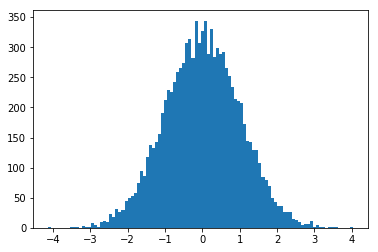

In [135]:
plt.hist(x1s, bins=100)
plt.show()

Wait... so that's it?! What is going on here?

In [159]:
%%timeit
def reject_r2():
    r2 = 1
    while r2 >= 1:
        y1 = np.random.random() * 2 - 1
        y2 = np.random.random() * 2 - 1
        r2 = y1 ** 2 + y2 ** 2
    return r2, y1, y2

def transform_r2(r2):
    return sqrt( -2 * log(r2) / r2)   

x1s = []
x2s = []

for i in range(n):    
    r2, y1, y2 = reject_r2()
    transformed_r2 = transform_r2(r2)

    x1 = transformed_r2  * y1
    x2 = transformed_r2 * y2
    
    x1s.append(x1)
    x2s.append(x2)

29.3 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


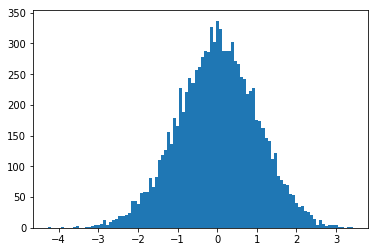

In [152]:
plt.hist(x1s, bins=100)
plt.show()

In [149]:
reject_r2()

(0.4312628669340129, -0.636776542033807, -0.16055685114463403)